In [1]:
import sys, os
import torch
import numpy as np 
import pandas as pd
sys.path.append("./src")
import torch.optim as opt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from torch.autograd import Variable
import model
import loss_function as loss_func
from loss_function import CircleLoss
import utils
import new_models
import anndata as ad
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
class dataset(Dataset):

    def __init__(self, counts, anno, time_point, batch_id):

        assert not len(counts) == 0, "Count is empty"
        # normalize the count
        self.libsizes = np.tile(np.sum(counts, axis = 1, keepdims = True), (1, counts.shape[1]))
        # is the tile necessary?
        
        self.counts_norm = counts/self.libsizes * 100
        self.counts_norm = np.log1p(self.counts_norm)
        self.counts = torch.FloatTensor(counts)

        # further standardize the count
        self.counts_stand = torch.FloatTensor(StandardScaler().fit_transform(self.counts_norm))
        self.anno = torch.Tensor(anno)
        self.libsizes = torch.FloatTensor(self.libsizes)
        # make sure the input time point are integer
        self.time_point = torch.LongTensor(time_point)
        self.batch_id = torch.Tensor(batch_id)
    def __len__(self):
        return self.counts.shape[0]
    
    def __getitem__(self, idx):
        # data original data, index the index of cell, label, corresponding labels, batch, corresponding batch number
        if self.anno is not None:
            sample = {"batch_id": self.batch_id[idx], "time_point": self.time_point[idx], "count": self.counts[idx,:], "count_stand": self.counts_stand[idx,:], "index": idx, "anno": self.anno[idx], "libsize": self.libsizes[idx]}
        else:
            sample = {"batch_id": self.batch_id[idx], "time_point": self.time_point[idx],  "count": self.counts[idx,:], "count_stand": self.counts_stand[idx,:], "index": idx, "libsize": self.libsizes[idx]}
        return sample

In [3]:
dir = r'./data/simulated/dataset1/'
batch_info = pd.read_csv(dir + 'batch_info.csv', index_col = 0)
pd.set_option('display.max_rows', None)
batch_info

,T0,T1,T2
batch_1,"(1736, 199)",NaN,NaN
batch_2,"(1665, 199)",NaN,NaN
batch_3,NaN,"(1649, 199)",NaN
batch_4,NaN,"(1593, 199)",NaN
batch_5,NaN,NaN,"(1688, 199)"
batch_6,NaN,NaN,"(1669, 199)"


In [4]:
class SupervisedContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.07):
        """
        Implementation of the loss described in the paper Supervised Contrastive Learning :
        https://arxiv.org/abs/2004.11362
        :param temperature: int
        """
        super(SupervisedContrastiveLoss, self).__init__()
        self.temperature = temperature

    def forward(self, projections, targets):
        """
        :param projections: torch.Tensor, shape [batch_size, projection_dim]
        :param targets: torch.Tensor, shape [batch_size]
        :return: torch.Tensor, scalar
        """
        device = torch.device("cuda") if projections.is_cuda else torch.device("cpu")

        dot_product_tempered = torch.mm(projections, projections.T) / self.temperature
        # Minus max for numerical stability with exponential. Same done in cross entropy. Epsilon added to avoid log(0)
        exp_dot_tempered = (
            torch.exp(dot_product_tempered - torch.max(dot_product_tempered, dim=1, keepdim=True)[0]) + 1e-5
        )

        mask_similar_class = (targets.unsqueeze(1).repeat(1, targets.shape[0]) == targets).to(device)
        mask_anchor_out = (1 - torch.eye(exp_dot_tempered.shape[0])).to(device)
        mask_combined = mask_similar_class * mask_anchor_out
        cardinality_per_samples = torch.sum(mask_combined, dim=1)

        log_prob = -torch.log(exp_dot_tempered / (torch.sum(exp_dot_tempered * mask_anchor_out, dim=1, keepdim=True)))
        supervised_contrastive_loss_per_sample = torch.sum(log_prob * mask_combined, dim=1) / cardinality_per_samples
        supervised_contrastive_loss = torch.mean(supervised_contrastive_loss_per_sample)

        return supervised_contrastive_loss

In [5]:
path = r'./data/simulated/dataset1/'
n_batches = 6
counts_rnas = []
labels = []
timepoints = []
batches = []
datasets = []
batch_lst = [1,3,5,2,4,6]
str_annos = []
str_batches = []
str_tp = []
# for batch_id in range(1, n_batches + 1):
for batch_id in batch_lst:
    counts_rnas.append(pd.read_csv(path + f'GxC{batch_id}.txt', sep = "\t", header = None).values.T)
    this_anno = pd.read_csv(path + f'cell_label{batch_id}.txt', sep = "\t", index_col = 0).values.squeeze()
    str_annos.append([('cell type '+str(i)) for i in this_anno])
    labels.append(pd.read_csv(path + f'cell_label{batch_id}.txt', sep = "\t", index_col = 0).values.squeeze())
    str_batches.append(['batch ' + str(batch_id)] * labels[-1].shape[0])
    batches.append(np.array([batch_id] * labels[-1].shape[0]))
    str_tp.append(['time point '+str(int((batch_id - 1)/2))] * labels[-1].shape[0])
    timepoints.append(np.array([int((batch_id - 1)/2)] * labels[-1].shape[0]))
    datasets.append(dataset(counts = counts_rnas[-1], anno = labels[-1], time_point = timepoints[-1], batch_id = batches[-1]))
    print(batch_id, 'Finished')

1 Finished
3 Finished
5 Finished
2 Finished
4 Finished
6 Finished


In [12]:
class new_ae(nn.Module):
    """\
    Description:
    --------------
        New model that separate the encoder and control backward gradient. (AUTOENCODER)

    """
    def __init__(self, datasets, Ks = [16, 8], batch_size = 64, interval = 10, lr = 5e-4, lambs = [1,1,1], seed = 0, device = device, contr_loss = None):
        super().__init__()
        # initialize the parameters
        self.datasets = datasets
        self.Ks = {"common_factor": Ks[0], 
                   "time_factor": Ks[1]}

        self.batch_size = batch_size
        self.interval = interval
        self.lr = lr
        self.lambs = lambs
        self.seed = seed 
        self.device = device
        self.contr = contr_loss

        if seed is not None:
            np.random.seed(seed)
            torch.manual_seed(seed)

        # create data loaders
        self.train_loaders = []
        # store the number of cells for each batch
        self.ncells = []
        # store the number of time points
        self.time_points = []
        for batch_id, dataset in enumerate(self.datasets):
            self.train_loaders.append(DataLoader(dataset, batch_size = self.batch_size, shuffle = True))

            self.ncells.append(dataset.counts.shape[0])

            # make sure that the genes are matched
            if batch_id == 0:
                self.ngenes = dataset.counts.shape[1]
            else:
                assert self.ngenes == dataset.counts.shape[1]
            # make sure that each dataset has one unique time point
            time_point = torch.unique(dataset.time_point)
            assert time_point.shape[0] == 1
            self.time_points.append(time_point)

        # create model
        # encoder for common biological factor
        self.Enc_c = model.Encoder(features = [self.ngenes, 128, 64, self.Ks["common_factor"]], dropout_rate = 0, negative_slope = 0.2).to(self.device)
        # encoder for time factor
        self.Enc_t = model.Encoder(features = [self.ngenes, 128, 64, self.Ks["time_factor"]], dropout_rate = 0, negative_slope = 0.2).to(self.device)
        # NOTE: reconstruct the original data, use all latent dimensions as input
        self.Dec = model.Decoder(features = [self.Ks["common_factor"] + self.Ks["time_factor"], 64, 128, self.ngenes], dropout_rate = 0, negative_slope = 0.2).to(self.device)
        # NOTE: classify the time point, out dim = number of unique time points, currently use only time dimensions as input, update the last layer to be linear
        # self.classifier = model.classifier(features = [self.Ks["time_factor"], 4, len(self.time_points)]).to(self.device)
        # use a linear classifier as stated in the paper
        self.classifier = nn.Linear(self.Ks["time_factor"], len(self.time_points)).to(self.device)

        # parameter when training the common biological factor
        self.param_common = [
            {'params': self.Enc_c.parameters()},
            {'params': self.Dec.parameters()}            
        ]

        # parameter when training the time factor
        self.param_time = [
            {'params': self.Enc_t.parameters()},
            {'params': self.classifier.parameters()}            
        ]

        # declare optimizer for time factor and common biological factor separately
        self.opt_common = opt.Adam(self.param_common, lr = self.lr)
        self.opt_time = opt.Adam(self.param_time, lr = self.lr)

    
    def train(self, nepochs = 50):
        lamb_pi = 1e-5
        ce_loss = nn.CrossEntropyLoss(reduction = 'mean')
                
        loss_tests = []
        loss_recon_tests = []
        loss_mmd_tests = []
        loss_class_tests = []

        for epoch in range(nepochs + 1):
            for data_batch in zip(*self.train_loaders):
                loss_recon = 0
                loss_class = 0
                loss_contr = 0
                zs_contr = {}
                zs_contr['time_point'] = []
                zs_contr['x'] = []
                zs_mmd = []
                # 1. train on common factor
                for batch_id, x in enumerate(data_batch):
                    z_c = self.Enc_c(x["count_stand"].to(self.device))
                    # freeze the gradient of Enc_t and classifier
                    # NOTE: use torch no_grad, set requires_grad to False alternatively
                    with torch.no_grad():
                        z_t = self.Enc_t(x["count_stand"].to(self.device))
                    z = torch.concat((z_c, z_t), dim = 1)
                    mu, pi, theta = self.Dec(z)

                    loss_recon += loss_func.ZINB(pi = pi, theta = theta, scale_factor = x["libsize"].to(self.device), ridge_lambda = lamb_pi).loss(y_true = x["count"].to(self.device), y_pred = mu)
                    zs_mmd.append(z_c)
                                
                loss_mmd = loss_func.maximum_mean_discrepancy(xs = zs_mmd, ref_batch = 0)
                loss = self.lambs[0] * loss_recon + self.lambs[1] * loss_mmd
                loss.backward()

                # NOTE: check the gradient of Enc_t and classifier to be None or 0
                with torch.no_grad():
                    for x in self.Enc_t.parameters():
                        assert (x.grad is None) or (torch.sum(x.grad.data.abs()) == 0)
                    for x in self.classifier.parameters():
                        assert (x.grad is None) or (torch.sum(x.grad.data.abs()) == 0)
                        # assert torch.sum(x.grad.data.abs()) < 1e-6
                    for x in self.Enc_c.parameters():
                        assert torch.sum(x.grad.data.abs()) != 0
                    for x in self.Dec.parameters():
                        assert torch.sum(x.grad.data.abs()) != 0
                     

                self.opt_common.step()
                self.opt_common.zero_grad()

                # 2. train on time factor
                n = 0 
                for batch_id, x in enumerate(data_batch):
                    # freeze the gradient of Enc_c
                    with torch.no_grad():
                        z_c = self.Enc_c(x["count_stand"].to(self.device))
                    z_t = self.Enc_t(x["count_stand"].to(self.device))
                    zs_contr['x'].append(z_t)
                    zs_contr['time_point'].append(x["time_point"])
                    t_pred = self.classifier(z_t)

                    loss_class += ce_loss(input = t_pred, target = x["time_point"].to(self.device))
                # TODO: contrastive loss, note that the same data batch have cells from only one cluster, contrastive loss should be added jointly
                loss_contr = self.contr(torch.cat(zs_contr['x']), torch.cat(zs_contr['time_point']))
                loss = self.lambs[2] * loss_class + loss_contr * self.lambs[3]
                loss.backward()

                # NOTE: check the gradient of Enc_c and Dec to be 0 or None
                with torch.no_grad():
                    for x in self.Enc_t.parameters():
                        assert torch.sum(x.grad.data.abs()) != 0
                    for x in self.classifier.parameters():
                        assert torch.sum(x.grad.data.abs()) != 0
                    for x in self.Enc_c.parameters():
                        assert (x.grad is None) or (torch.sum(x.grad.data.abs()) == 0)
                        # assert torch.sum(x.grad.data.abs()) < 1e-6
                    for x in self.Dec.parameters():
                        assert (x.grad is None) or (torch.sum(x.grad.data.abs()) == 0)
                        # assert torch.sum(x.grad.data.abs()) < 1e-6

                self.opt_time.step()
                self.opt_time.zero_grad()
            
            # TEST:
            if epoch % self.interval == 0:
                loss_recon_test = 0
                loss_mmd_test = 0
                loss_class_test = 0
                
                zs_mmd = []
                with torch.no_grad():
                    for dataset in self.datasets:
                        z_c = self.Enc_c(dataset.counts_stand.to(self.device))
                        z_t = self.Enc_t(dataset.counts_stand.to(self.device))
                        z = torch.concat((z_c, z_t), dim = 1)
                        mu, pi, theta = self.Dec(z)
                        t_pred = self.classifier(z_t)
                        zs_mmd.append(z_c)

                        loss_class_test += ce_loss(input = t_pred, target = dataset.time_point.to(self.device))
                        loss_recon_test += loss_func.ZINB(pi = pi, theta = theta, scale_factor = dataset.libsizes.to(self.device), ridge_lambda = lamb_pi).loss(y_true = dataset.counts.to(self.device), y_pred = mu)
                    
                    loss_mmd_test = loss_func.maximum_mean_discrepancy(xs = zs_mmd, ref_batch = 0)
                    loss_test = self.lambs[0] * loss_recon + self.lambs[1] * loss_mmd_test + self.lambs[2] * loss_class_test
                    
                    print('Epoch {}, Validating Loss: {:.4f}'.format(epoch, loss_test.item()))
                    info = [
                        'loss reconstruction: {:.5f}'.format(loss_recon_test.item()),
                        'loss mmd: {:.5f}'.format(loss_mmd_test.item()),
                        'loss classification: {:.5f}'.format(loss_class_test.item())
                    ]
                    for i in info:
                        print("\t", i)              
                    
                    loss_tests.append(loss_test.item())
                    loss_recon_tests.append(loss_recon.item())
                    loss_mmd_tests.append(loss_mmd_test.item())
                    loss_class_tests.append(loss_class_test.item())
    
                    # # update for early stopping 
                    # if loss_test.item() < best_loss:# - 0.01 * abs(best_loss):
                        
                    #     best_loss = loss.item()
                    #     torch.save(self.state_dict(), f'../check_points/model.pt')
                    #     count = 0
                    # else:
                    #     count += 1
                    #     print(count)
                    #     if count % int(nepochs/self.interval) == 0:
                    #         self.opt_time.param_groups[0]['lr'] *= 0.5
                    #         self.opt_common.param_groups[0]['lr'] *= 0.5
                    #         print('Epoch: {}, shrink lr to {:.4f}'.format(epoch + 1, self.opt_time.param_groups[0]['lr']))
                    #         if self.opt_time.param_groups[0]['lr'] < 1e-6:
                    #             break
                    #         else:
                    #             self.load_state_dict(torch.load(f'../check_points/model.pt'))
                    #             count = 0  

        return loss_tests, loss_recon_tests, loss_mmd_tests, loss_class_tests

In [13]:
# model1 = new_models.new_ae(datasets = datasets, Ks = [12, 4], batch_size = 128, interval = 10, lr = 5e-4, lambs = [1, 1e-2, 10], seed = 0, device = device)
m, gamma = 0.3, 0
lambs = [1, 0.5, 10, 0.1]
contr_loss = CircleLoss(m = m, gamma = gamma)
# contr_loss = SupervisedContrastiveLoss()
model1 = new_ae(datasets = datasets, Ks = [12, 4], batch_size = 128, interval = 10, 
                lr = 5e-4, lambs = lambs, seed = 0, device = device, contr_loss = contr_loss)
# model1 = new_ae(datasets = datasets, Ks = [12, 4], batch_size = 128, interval = 10, lr = 5e-4, lambs = [1, 1e-3, 10], seed = 0, device = device)

In [14]:
losses, *_ = model1.train(nepochs = 100)

Epoch 0, Validating Loss: 134.1145
	 loss reconstruction: 24.34352
	 loss mmd: 0.06669
	 loss classification: 10.92737
Epoch 10, Validating Loss: 84.9667
	 loss reconstruction: 14.13430
	 loss mmd: 0.04104
	 loss classification: 7.07854
Epoch 20, Validating Loss: 75.5677
	 loss reconstruction: 11.66182
	 loss mmd: 0.03763
	 loss classification: 6.38223
Epoch 30, Validating Loss: 68.1981
	 loss reconstruction: 10.54293
	 loss mmd: 0.03824
	 loss classification: 5.76223
Epoch 40, Validating Loss: 54.8498
	 loss reconstruction: 10.33012
	 loss mmd: 0.03721
	 loss classification: 4.45659
Epoch 50, Validating Loss: 42.1346
	 loss reconstruction: 10.26131
	 loss mmd: 0.03646
	 loss classification: 3.19283
Epoch 60, Validating Loss: 33.4763
	 loss reconstruction: 10.21197
	 loss mmd: 0.03611
	 loss classification: 2.31512
Epoch 70, Validating Loss: 25.5586
	 loss reconstruction: 10.17968
	 loss mmd: 0.03564
	 loss classification: 1.53691
Epoch 80, Validating Loss: 19.4318
	 loss reconstructio

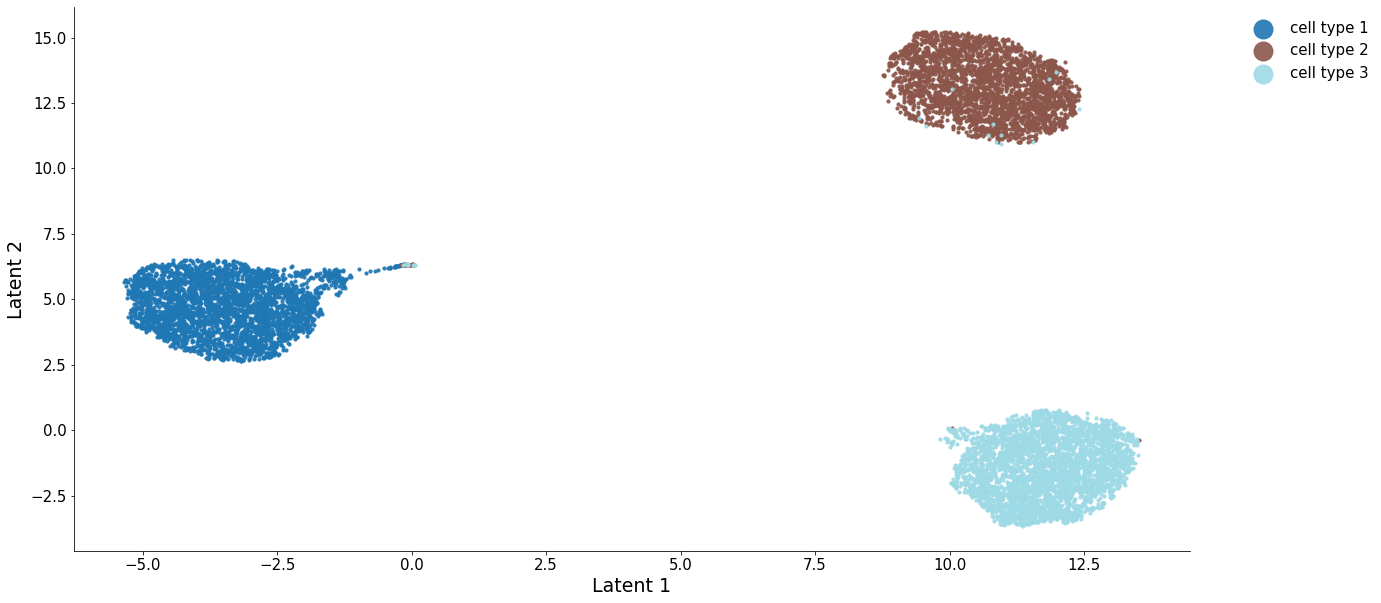

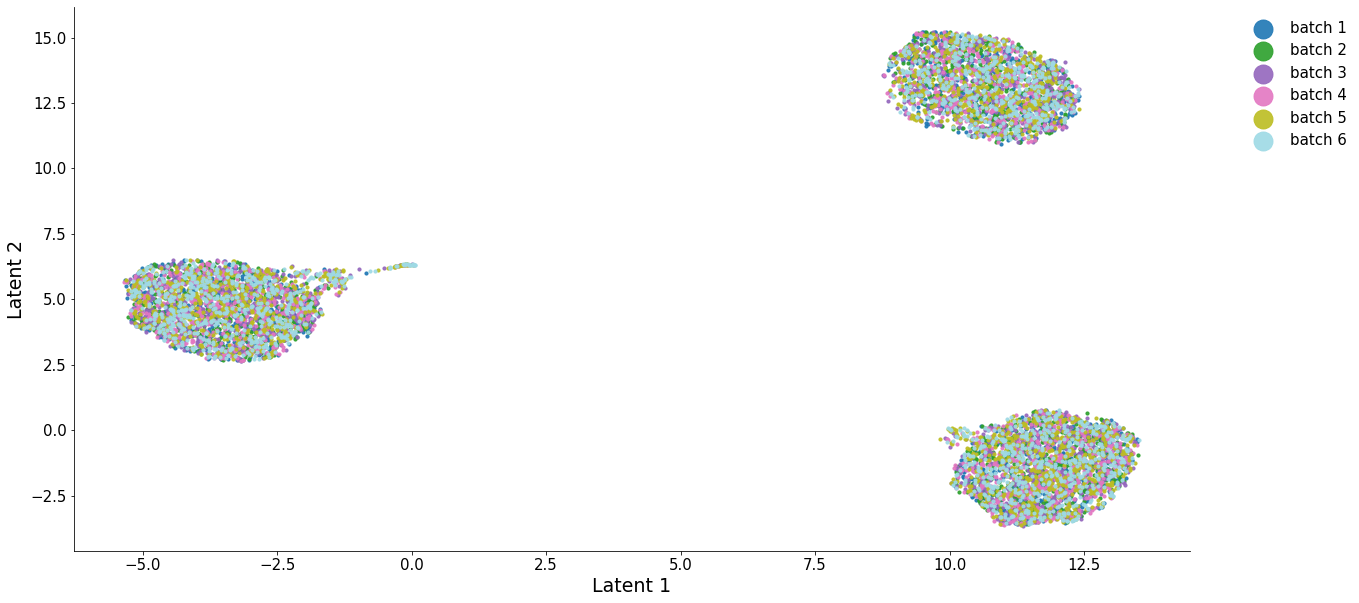

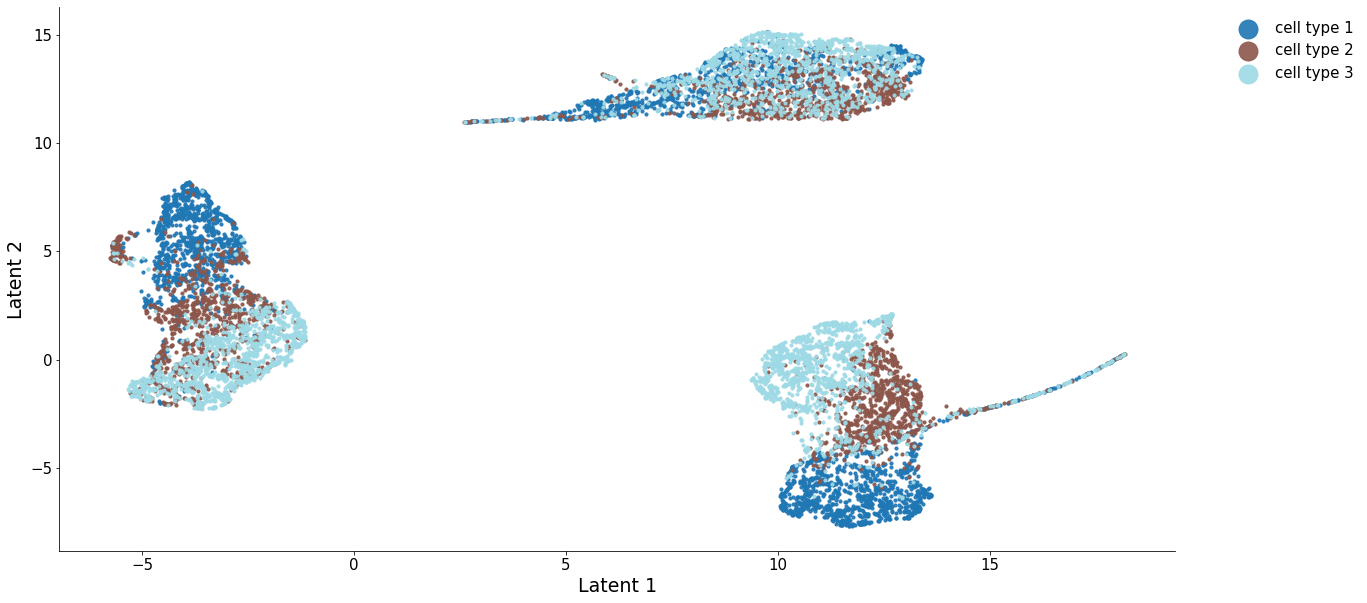

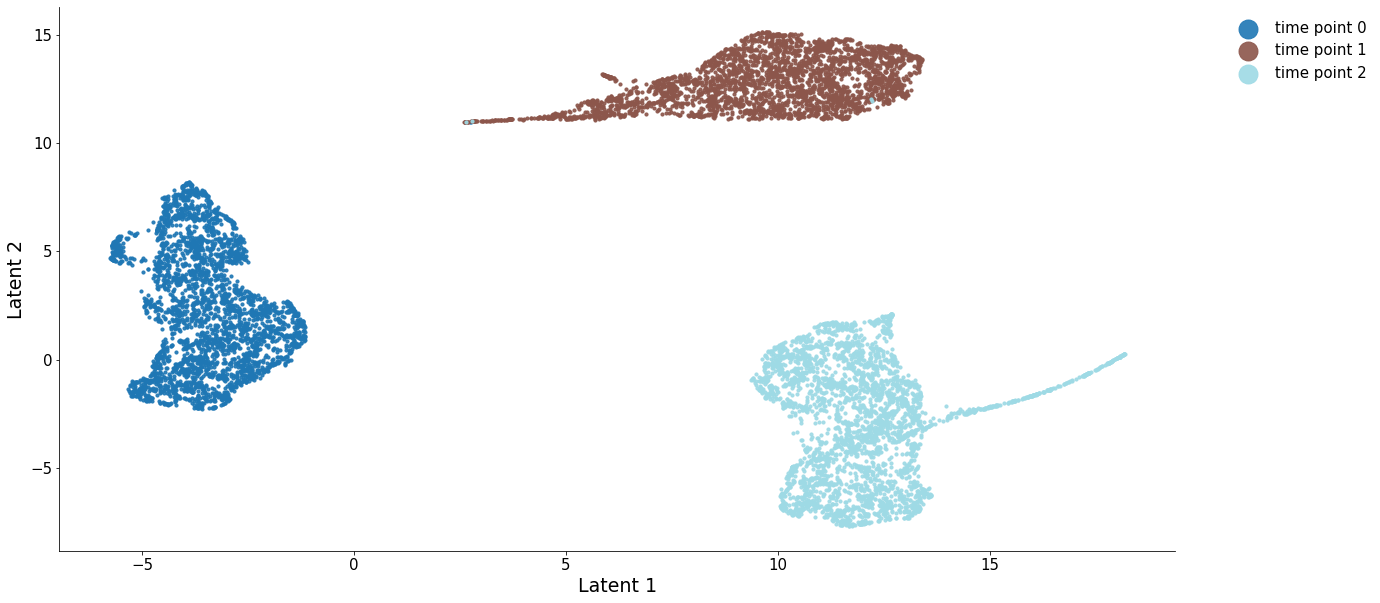

In [15]:
from umap import UMAP

z_cs = []
z_ts = []
zs = []
with torch.no_grad():
    for x in datasets:
        z_c = model1.Enc_c(x.counts_stand.to(model1.device))
        z_t = model1.Enc_t(x.counts_stand.to(model1.device))
        z_cs.append(z_c.cpu().detach().numpy())
        z_ts.append(z_t.cpu().detach().numpy())
        zs.append(torch.cat((z_c, z_t), dim = 1).cpu().detach().numpy())

    # UMAP
    umap_op = UMAP(min_dist = 0.1, random_state = 0)
    z_cs_umap = umap_op.fit_transform(np.concatenate(z_cs, axis = 0))
    z_ts_umap = umap_op.fit_transform(np.concatenate(z_ts, axis = 0))
    zs_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0))

    z_ts_umaps = []
    z_cs_umaps = []
    zs_umaps = []
    for batch in range(n_batches):
        if batch == 0:
            start_pointer = 0
            end_pointer = start_pointer + zs[batch].shape[0]
            z_ts_umaps.append(z_ts_umap[start_pointer:end_pointer,:])
            z_cs_umaps.append(z_cs_umap[start_pointer:end_pointer,:])
            zs_umaps.append(zs_umap[start_pointer:end_pointer,:])

        elif batch == (n_batches - 1):
            start_pointer = start_pointer + zs[batch - 1].shape[0]
            z_ts_umaps.append(z_ts_umap[start_pointer:,:])
            z_cs_umaps.append(z_cs_umap[start_pointer:,:])
            zs_umaps.append(zs_umap[start_pointer:,:])

        else:
            start_pointer = start_pointer + zs[batch - 1].shape[0]
            end_pointer = start_pointer + zs[batch].shape[0]
            z_ts_umaps.append(z_ts_umap[start_pointer:end_pointer,:])
            z_cs_umaps.append(z_cs_umap[start_pointer:end_pointer,:])
            zs_umaps.append(zs_umap[start_pointer:end_pointer,:])
    comment = r'_circle_{}_{}_{}_'.format(m, gamma, lambs[-1])
#     comment = r'SupContr_{}'.format(lambs[-1])
#     result_dir = r'./simulated_results/new_results/simulated/'
    result_dir = None
    utils.plot_latent(zs = z_cs_umaps, annos = str_annos, mode = "joint", save = (result_dir + comment+"common_dims_celltypes.png") if result_dir else None , markerscale = 6)
    utils.plot_latent(zs = z_cs_umaps, annos = str_batches, mode = "joint", save = (result_dir + comment+"common_dims_batches.png".format()) if result_dir else None, markerscale = 6)
    utils.plot_latent(zs = z_ts_umaps, annos = str_annos, mode = "joint", save = (result_dir + comment+"time_dims_celltypes.png".format()) if result_dir else None, markerscale = 6)
    utils.plot_latent(zs = z_ts_umaps, annos = str_tp, mode = "joint", save = (result_dir + comment+"time_dims_timepoint.png".format()) if result_dir else None, markerscale = 6)

In [19]:
for i in model1.Enc_t.parameters():
    print(i.shape)
z_t[:4, :]

torch.Size([128, 200])
torch.Size([128])
torch.Size([128])
torch.Size([128])
torch.Size([64, 128])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([4, 64])
torch.Size([4])


tensor([[10.2961, -6.8788, 10.2917,  3.1199],
        [ 5.2932, -0.6368,  4.1143, -0.1623],
        [ 4.6005, -0.5859,  3.5595, -0.0731],
        [ 4.5136, -1.0640,  3.7426,  0.1308]], device='cuda:0')

# VAE

In [10]:
class new_vae(nn.Module):
    """\
    Description:
    --------------
        New model that separate the encoder and control backward gradient. 

    """
    def __init__(self, datasets, Ks = [16, 8], batch_size = 64, interval = 10, lr = 5e-4, lambs = [1,1,1], seed = 0, device = device):
        super().__init__()
        # initialize the parameters
        self.datasets = datasets
        self.Ks = {"common_factor": Ks[0], 
                   "time_factor": Ks[1]}

        self.batch_size = batch_size
        self.interval = interval
        self.lr = lr
        self.lambs = lambs
        self.seed = seed 
        self.device = device

        if seed is not None:
            np.random.seed(seed)
            torch.manual_seed(seed)

        # create data loaders
        self.train_loaders = []
        # store the number of cells for each batch
        self.ncells = []
        # store the number of time points
        self.time_points = []
        for batch_id, dataset in enumerate(self.datasets):
            self.train_loaders.append(DataLoader(dataset, batch_size = self.batch_size, shuffle = True))

            self.ncells.append(dataset.counts.shape[0])

            # make sure that the genes are matched
            if batch_id == 0:
                self.ngenes = dataset.counts.shape[1]
            else:
                assert self.ngenes == dataset.counts.shape[1]
            # make sure that each dataset has one unique time point
            time_point = torch.unique(dataset.time_point)
            assert time_point.shape[0] == 1
            self.time_points.append(time_point)

        # create model
        # encoder for common biological factor
        self.Enc_c = model.Encoder_var(features = [self.ngenes, 256, 64, self.Ks["common_factor"]], dropout_rate = 0, negative_slope = 0.2).to(self.device)
        # encoder for time factor
        self.Enc_t = model.Encoder_var(features = [self.ngenes, 256, 64, self.Ks["time_factor"]], dropout_rate = 0, negative_slope = 0.2).to(self.device)
        # NOTE: reconstruct the original data, use all latent dimensions as input
        self.Dec = model.Decoder(features = [self.Ks["common_factor"] + self.Ks["time_factor"], 64, 256, self.ngenes], dropout_rate = 0, negative_slope = 0.2).to(self.device)
        # NOTE: classify the time point, out dim = number of unique time points, currently use only time dimensions as input, update the last layer to be linear
        # self.classifier = model.classifier(features = [self.Ks["time_factor"], 4, len(self.time_points)]).to(self.device)
        # use a linear classifier as stated in the paper
        self.classifier = nn.Linear(self.Ks["time_factor"], len(self.time_points)).to(self.device)
        # parameter when training the common biological factor
        self.param_common = [
            {'params': self.Enc_c.parameters()},
            {'params': self.Dec.parameters()}            
        ]

        # parameter when training the time factor
        self.param_time = [
            {'params': self.Enc_t.parameters()},
            {'params': self.classifier.parameters()}            
        ]

        # declare optimizer for time factor and common biological factor separately
        self.opt_common = opt.Adam(self.param_common, lr = self.lr)
        self.opt_time = opt.Adam(self.param_time, lr = self.lr)



    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()

        eps = torch.FloatTensor(std.size()).normal_().to(self.device)
        eps = Variable(eps)
        return eps.mul(std).add_(mu)
            
    def train(self, nepochs = 50):
        lamb_pi = 1e-5
        # TODO: in the vanilla vae, beta should be 1, in beta-vae, beta >1, the visualization for both cases are not good. Try beta with smaller value
        beta = 1e-3
        ce_loss = nn.CrossEntropyLoss(reduction = 'mean')

        loss_tests = []
        loss_recon_tests = []
        loss_kl_tests = []
        loss_mmd_tests = []
        loss_class_tests = []

        for epoch in range(nepochs + 1):
            for data_batch in zip(*self.train_loaders):
                loss_recon = 0
                loss_kl = 0

                zs_mmd = []
                # 1. train on common factor
                for batch_id, x in enumerate(data_batch):
                    z_mu_c, z_log_var_c = self.Enc_c(x["count_stand"].to(self.device))
                    # freeze the gradient of Enc_t and classifier
                    # NOTE: use torch no_grad, set requires_grad to False alternatively
                    with torch.no_grad():
                        z_mu_t, z_log_var_t = self.Enc_t(x["count_stand"].to(self.device))
                    z_mu = torch.concat((z_mu_c, z_mu_t), dim = 1)
                    z_log_var = torch.concat((z_log_var_c, z_log_var_t), dim = 1)
                    z = self.reparametrize(z_mu, z_log_var)
                    mu, pi, theta = self.Dec(z)

                    loss_recon += loss_func.ZINB(pi = pi, theta = theta, scale_factor = x["libsize"].to(self.device), ridge_lambda = lamb_pi).loss(y_true = x["count"].to(self.device), y_pred = mu)
                    # kl-divergence
                    loss_kl += torch.sum(z_mu.pow(2).add_(z_log_var.exp()).mul_(-1).add_(1).add_(z_log_var)).mul_(-0.5)
                    # TODO: here I use z before sampled, an alternative is to use the after sample z
                    zs_mmd.append(z_mu_c)
                    
                loss_mmd = loss_func.maximum_mean_discrepancy(xs = zs_mmd, ref_batch = 0)
                # beta = 1 for VAE, beta > 1 for beta-vae
                loss = self.lambs[0] * loss_recon + self.lambs[1] * loss_mmd + beta * loss_kl
                loss.backward()

                # NOTE: check the gradient of Enc_t and classifier to be None or 0
                with torch.no_grad():
                    for x in self.Enc_t.parameters():
                        assert (x.grad is None) or (torch.sum(x.grad.data.abs()) == 0)
                    for x in self.classifier.parameters():
                        assert (x.grad is None) or (torch.sum(x.grad.data.abs()) == 0)
                        # assert torch.sum(x.grad.data.abs()) < 1e-6
                    for x in self.Enc_c.parameters():
                        assert torch.sum(x.grad.data.abs()) != 0
                    for x in self.Dec.parameters():
                        assert torch.sum(x.grad.data.abs()) != 0
                     

                self.opt_common.step()
                self.opt_common.zero_grad()

                loss_class = 0
                loss_kl = 0
                # 2. train on time factor
                for batch_id, x in enumerate(data_batch):
                    # freeze the gradient of Enc_c
                    with torch.no_grad():
                        z_mu_c, z_log_var_c = self.Enc_c(x["count_stand"].to(self.device))
                    z_mu_t, z_log_var_t = self.Enc_t(x["count_stand"].to(self.device))

                    # TODO: should we still sample?? Here I sample again, and then we need to calculate kl loss for the samples
                    z_t = self.reparametrize(z_mu_t, z_log_var_t)
                    t_pred = self.classifier(z_t)
                    loss_class += ce_loss(input = t_pred, target = x["time_point"].to(self.device))

                    loss_kl += torch.sum(z_mu_t.pow(2).add_(z_log_var_t.exp()).mul_(-1).add_(1).add_(z_log_var_t)).mul_(-0.5)

                # TODO: contrastive loss, note that the same data batch have cells from only one cluster, contrastive loss should be added jointly
                
                loss = self.lambs[2] * loss_class + beta * loss_kl
                loss.backward()

                # NOTE: check the gradient of Enc_c and Dec to be 0 or None
                with torch.no_grad():
                    for x in self.Enc_t.parameters():
                        assert torch.sum(x.grad.data.abs()) != 0
                    for x in self.classifier.parameters():
                        assert torch.sum(x.grad.data.abs()) != 0
                    for x in self.Enc_c.parameters():
                        assert (x.grad is None) or (torch.sum(x.grad.data.abs()) == 0)
                        # assert torch.sum(x.grad.data.abs()) < 1e-6
                    for x in self.Dec.parameters():
                        assert (x.grad is None) or (torch.sum(x.grad.data.abs()) == 0)
                        # assert torch.sum(x.grad.data.abs()) < 1e-6

                self.opt_time.step()
                self.opt_time.zero_grad()
            
            # TEST:
            if epoch % self.interval == 0:
                loss_recon_test = 0
                loss_class_test = 0
                loss_kl_test = 0
                
                zs_mmd = []
                with torch.no_grad():
                    for dataset in self.datasets:
                        z_mu_c, z_log_var_c = self.Enc_c(dataset.counts_stand.to(self.device))
                        z_mu_t, z_log_var_t = self.Enc_t(dataset.counts_stand.to(self.device))

                        z_mu = torch.concat((z_mu_c, z_mu_t), dim = 1)
                        z_log_var = torch.concat((z_log_var_c, z_log_var_t), dim = 1)
                        z = self.reparametrize(z_mu, z_log_var)
                        mu, pi, theta = self.Dec(z)
                        # z_t
                        t_pred = self.classifier(z[:, -z_mu_t.shape[1]:])
                        # TODO: here I use mu before sample, an alternative is to use z after sample
                        zs_mmd.append(z_mu_c)

                        loss_class_test += ce_loss(input = t_pred, target = dataset.time_point.to(self.device))
                        loss_recon_test += loss_func.ZINB(pi = pi, theta = theta, scale_factor = dataset.libsizes.to(self.device), ridge_lambda = lamb_pi).loss(y_true = dataset.counts.to(self.device), y_pred = mu)
                        loss_kl_test += torch.sum(z_mu.pow(2).add_(z_log_var.exp()).mul_(-1).add_(1).add_(z_log_var)).mul_(-0.5)

                    loss_mmd_test = loss_func.maximum_mean_discrepancy(xs = zs_mmd, ref_batch = 0)
                    loss_test = self.lambs[0] * loss_recon + self.lambs[1] * loss_mmd_test + self.lambs[2] * loss_class_test + beta * loss_kl_test
                    
                    print('Epoch {}, Validating Loss: {:.4f}'.format(epoch, loss_test.item()))
                    info = [
                        'loss reconstruction: {:.5f}'.format(loss_recon_test.item()),
                        'loss kl: {:.5f}'.format(loss_kl_test.item()),
                        'loss mmd: {:.5f}'.format(loss_mmd_test.item()),
                        'loss classification: {:.5f}'.format(loss_class_test.item())
                    ]
                    for i in info:
                        print("\t", i)              
                    
                    loss_tests.append(loss_test.item())
                    loss_recon_tests.append(loss_recon.item())
                    loss_mmd_tests.append(loss_mmd_test.item())
                    loss_class_tests.append(loss_class_test.item())
                    loss_kl_tests.append(loss_kl_test.item())

                    # # update for early stopping 
                    # if loss_test.item() < best_loss:# - 0.01 * abs(best_loss):
                        
                    #     best_loss = loss.item()
                    #     torch.save(self.state_dict(), f'../check_points/model.pt')
                    #     count = 0
                    # else:
                    #     count += 1
                    #     print(count)
                    #     if count % int(nepochs/self.interval) == 0:
                    #         self.opt_time.param_groups[0]['lr'] *= 0.5
                    #         self.opt_common.param_groups[0]['lr'] *= 0.5
                    #         print('Epoch: {}, shrink lr to {:.4f}'.format(epoch + 1, self.opt_time.param_groups[0]['lr']))
                    #         if self.opt_time.param_groups[0]['lr'] < 1e-6:
                    #             break
                    #         else:
                    #             self.load_state_dict(torch.load(f'../check_points/model.pt'))
                    #             count = 0                            

        return loss_tests, loss_recon_tests, loss_kl_tests, loss_mmd_tests, loss_class_tests